# Mathematical model of antibiotic resistance N. gonorrhoeae spread

### Transmission model
* $Sen$ and $Res$ indicate the antibitotic-sensitive and -resistand N. gonorrhoeae strains
* $G = \{L,H\}$ is the set of low and high sexual activity groups, $i \in G$
* Each sexual activity group $N_i$ consists of:
    * susceptible hosts $S_i$
    * hosts infected with an antibiotic-sensitive strain, $I_{Sen_i}$
    * hosts infected with an antibiotic-resistant strain, $I_{Res_i}$
* Hosts are redistributed to either the same of the other sexual activity group at rate $\gamma$
* Hosts leave or enter the population at rate $\alpha$
* Susceptible hosts become infected depending on:
    * the partner change rate, $\pi_i$
    * the transmission probability per partnership, $\beta_{ij}$
    * the sexual mixing matrix $\rho_{ij}$ 
* Hosts infected with an antibiotic-sensitive strain can:
    * recover spontaneously at rate $\nu$
    * receive treatment at rate $\tau$
* Hosts receiving treatment recover at rate $\tau(1 - \mu)$
* Hosts decelop resistance during treatment with probability $\mu$
* Host infected with an antibiotic-resistance strain can only recover spontaneously at rate $\nu$
    
The sexual mixing matrix describes how many partnerships are formed within and outside the host's activity group:

$$ \rho_{ij} = \epsilon \delta_{ij} + (1 - \epsilon) \frac{\pi_j N_j}{\sum_{k \in G} \pi_k N_k} $$

Here, $\delta_{ij} = 1$ if $i = j$ and 0 otherwise. Model parameters were estimated from sexual behavior data, calibrated trough model simulation or informed by literature. The parameters can be found on page 5 of the article

In [1]:
## imports for the math model
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from math_model_functions import *

## imports for the network model
import networkx as nx
from networkx.utils.random_sequence import (powerlaw_sequence)
from numba import jit
from network_model import *

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
# import networkx.utils.create_degree_sequence as create_degree_sequence
%matplotlib notebook


### MSM Parameters
Parameters for the "Men having sex with men group"

In [3]:
Nh = 5.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.41, 30.49])


BLL = np.array([0.42,0.59,0.77])
BHH = np.array([0.25,0.30,0.40])
alpha = 1 / 29


gamma = 1
epsilon = np.array([0.30,0.57,0.80])
phi = np.array([0.48,0.64,0.81])
mu = 1e-3
D = np.array([0.14,0.19,0.25])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_msm = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_msm.append(odeint(math_model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_msm = np.array(sol_msm)

### HMW Parameters
Parameters for the heterosexual men

In [4]:
Nh = 6.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.25, 4.57])


alpha = 1 / 29
BLL = np.array([0.79,0.87,0.94])
BHH = np.array([0.63,0.72,0.81])

gamma = 1
epsilon = np.array([0.53,0.73,0.89])
phi = np.array([0.36,0.50,0.66])
mu = 1e-3
D = np.array([0.46,0.55,0.66])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_hmw = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_hmw.append(odeint(math_model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_hmw = np.array(sol_hmw)

### Figures and plots

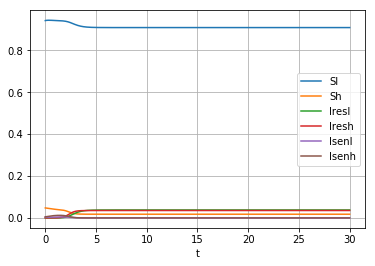

In [5]:
plt.figure()
plt.plot(t, sol_msm[1,:, 0], label='Sl')
plt.plot(t, sol_msm[1,:, 1], label='Sh')
plt.plot(t, sol_msm[1,:, 2], label='Iresl')
plt.plot(t, sol_msm[1,:, 3], label='Iresh')
plt.plot(t, sol_msm[1,:, 4], label='Isenl')
plt.plot(t, sol_msm[1,:, 5], label='Isenh')

plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

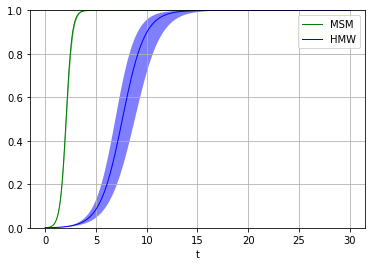

In [6]:
plt.figure()
ratio_sol_msm = (sol_msm[:,:, 2] + sol_msm[:,:, 3])/(sol_msm[:,:, 2] + sol_msm[:,:, 3] + sol_msm[:,:, 4] + sol_msm[:,:, 5])
plt.plot(t, ratio_sol_msm[1,:], label = "MSM", c = "g",linewidth=1)
plt.fill_between(t,ratio_sol_msm[0,:], ratio_sol_msm[2,:], alpha=0.5, facecolor = "g")
ratio_sol_hmw = (sol_hmw[:,:, 2] + sol_hmw[:,:, 3])/(sol_hmw[:,:, 2] + sol_hmw[:,:, 3] + sol_hmw[:,:, 4] + sol_hmw[:,:, 5])
plt.plot(t, ratio_sol_hmw[1,:], label = "HMW", c = "b",linewidth=1)
plt.fill_between(t,ratio_sol_hmw[0,:], ratio_sol_hmw[2,:], alpha=0.5, facecolor = "b")
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.ylim(0,1)
plt.show()

# Simple Contact network

## Build a network

exponent = -2.40
graph has 1371 parallel edges
size of largest connected component = 877


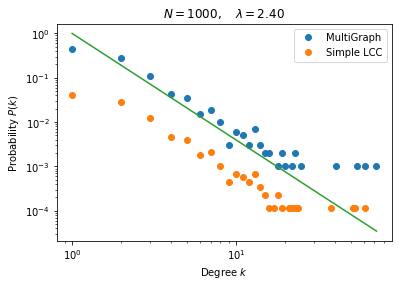

<function networkx.generators.random_graphs.powerlaw_cluster_graph(n, m, p, seed=None)>

In [2]:
#### code from http://nbviewer.jupyter.org/gist/Midnighter/248f1a5d8c21b39525ae

exp = 2.4
seed = 123456789
num = 1000
print("exponent = -{0:.2f}".format(exp))
sequence = create_degree_sequence(num, powerlaw_sequence, exponent=exp)
graph = nx.configuration_model(sequence, seed=seed)
# count parallel edges and avoid counting A-B as well as B-A
num_par = sum(
    len(graph[node][neigh]) for node in graph
    for neigh in graph.neighbors(node)) // 2
print("graph has {0:d} parallel edges".format(num_par))
loops = graph.selfloop_edges()
# remove them
graph = nx.Graph(graph)
graph.remove_edges_from(loops)
# get largest connected component
# unfortunately, the iterator over the components is not guaranteed to be sorted by size
components = sorted(nx.connected_components(graph), key=len, reverse=True)
lcc = graph.subgraph(components[0])
print("size of largest connected component = {0:d}".format(len(lcc)))
# new degree sequence
simple_seq = [deg for (node, deg) in lcc.degree()]
# create histograms
counts = np.bincount(sequence)
mask = (counts > 0)
plt.figure()
plt.plot(
    np.arange(len(counts))[mask],
    counts[mask] / counts.sum(),
    "o",
    label="MultiGraph")
simple_counts = np.bincount(simple_seq)
mask = (simple_counts > 0)
# distribution is shifted for visibility
plt.plot(
    np.arange(len(simple_counts))[mask],
    simple_counts[mask] / simple_counts.sum() / 10.0,
    "o",
    label="Simple LCC")
x = np.arange(1, len(counts))
plt.plot(x, np.power(x, -exp))
plt.xlabel(r"Degree $k$")
plt.xscale("log")
plt.ylabel(r"Probability $P(k)$")
plt.yscale("log")
plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(num, exp))
plt.legend(loc="best")
plt.show()
nx.powerlaw_cluster_graph

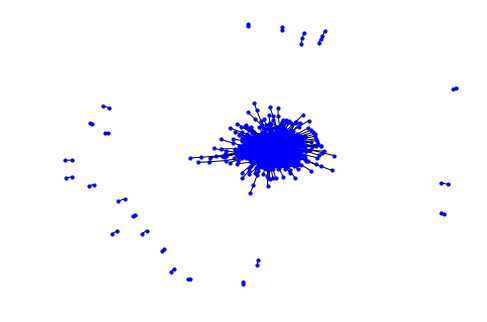

In [3]:
plt.figure()
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color='b', node_size=10, with_labels=False)
plt.show()

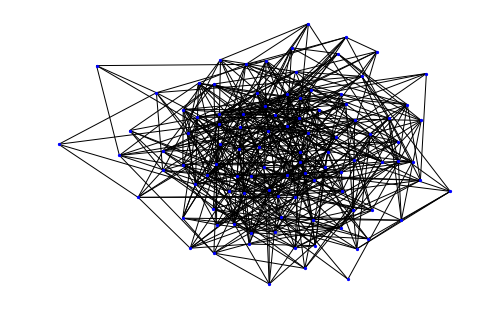

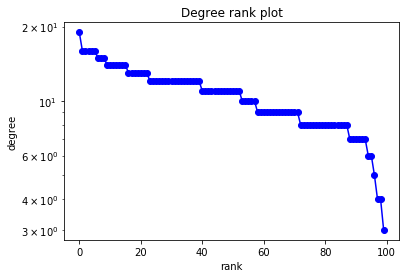

In [3]:
p = 0.1
num = 100
graph = nx.fast_gnp_random_graph(num, p, seed=seed, directed=False)

plt.figure()
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color='b', node_size=5, with_labels=False)
plt.show()

plt.figure()
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)

plt.semilogy(degree_sequence, 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

## Implementation of disease spreading

In [4]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds

init = np.random.choice(len(graph), 10, replace=False)

t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)
D = 0.19 * time_step
mu = 1e-3

# constants of model
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# keep track of infecteds and steps
num_steps = int(t_tot / dt)
num_infected = np.zeros((2, num_steps))
num_res = np.zeros((2, num_steps))

for sextype in range(2):
    phi = PHI[sextype]
    beta = BETA[sextype]

    beta = 1 - (1 - beta)**(1 / time_step)
    nu = 2e-3 * (1 - phi)
    tau = 8e-3 * phi

    
    num_res[sextype,:], num_infected[sextype,:]= network_model(beta, tau, nu, mu, init, num_steps, copy.deepcopy(graph), True)

100%|██████████| 7300/7300 [00:09<00:00, 804.21it/s]


## Plotting

84.9798630137


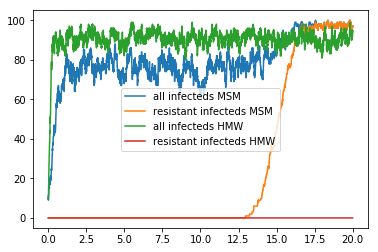

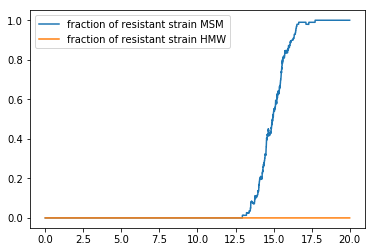

In [5]:
# plot number of infecteds
t = np.linspace(0,t_tot, num_steps)    
plt.figure()
print(np.mean(num_infected))
plt.plot(t, num_infected[0,:], label='all infecteds MSM')
plt.plot(t, num_res[0,:], label='resistant infecteds MSM')
plt.plot(t, num_infected[1,:], label='all infecteds HMW')
plt.plot(t, num_res[1,:], label='resistant infecteds HMW')
plt.legend()
plt.show()

plt.figure()
plt.plot(t,num_res[0,:]/num_infected[0,:], label='fraction of resistant strain MSM')
plt.plot(t,num_res[1,:]/num_infected[1,:], label='fraction of resistant strain HMW')
# plt.plot(num_res)
plt.legend()
plt.show()

In [10]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds

init = np.random.choice(len(graph), 10, replace=False)

t = 0
t_tot = 10
time_step = 365
dt = 1 / (time_step)
D = 0.19 * time_step
mu = 1e-3

# constants of model
PHI = [0.65, 0.50]
BETA = np.linspace(0.15, 0.3, 10)

# keep track of infecteds and steps
num_steps = int(t_tot / dt)
num_infected = np.zeros((len(BETA), num_steps))
num_res = np.zeros((len(BETA), num_steps))

for i, beta in enumerate(BETA):
    phi = PHI[0]

    BETA = 1 - (1 - BETA)**(1 / time_step)
    nu = 2e-3 * (1 - phi)
    tau = 8e-3 * phi
    num_res[i,:], num_infected[i,:]= network_model(beta, tau, nu,mu, init, num_steps, copy.deepcopy(graph))


100%|██████████| 3650/3650 [00:00<00:00, 937317.68it/s]


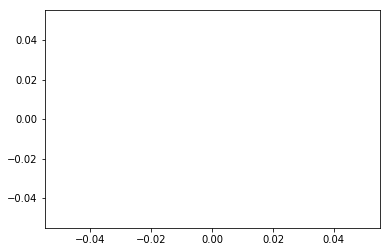

/home/sesegma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/sesegma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


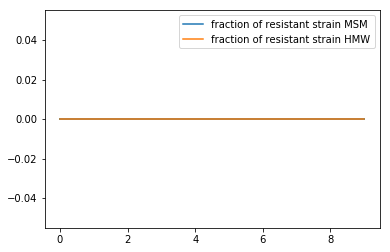

In [14]:
t = np.linspace(0,t_tot, num_steps)    
plt.figure()

plt.plot(BETA, num_infected[:,-1], label='all infecteds %i' % BETA[i])
plt.plot(BETA, num_res[:,-1], label='resistant infecteds %i'% BETA[i])
# plt.legend()
plt.show()

# plt.figure()
# plt.plot(t,num_res[0,:]/num_infected[0,:], label='fraction of resistant strain MSM')
# plt.plot(t,num_res[1,:]/num_infected[1,:], label='fraction of resistant strain HMW')
# # plt.plot(num_res)
# plt.legend()
# plt.show()

In [17]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds

init = np.random.choice(len(graph), 10, replace=False)

t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)
D = 0.19 * time_step
mu = 1e-3

# constants of model
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# keep track of infecteds and steps
# num_steps = int(t_tot / dt)

# for sextype in range(2):
sextype = 0

phi = PHI[sextype]
beta = BETA[sextype]

beta = 1 - (1 - beta)**(1 / time_step)
nu = 2e-3 * (1 - phi)
tau = 8e-3 * phi


network_model(beta, tau, nu, mu, init, 0, graph, doInit=True)

# get values of disease status
values = []
for j in range(len(graph.nodes())):
    if graph.node[j]["Data"].disease_status == 0:
        values.append("Black")
    elif graph.node[j]["Data"].disease_status == 1:
        values.append("Blue")
    elif graph.node[j]["Data"].disease_status == 2:
        values.append("Red")

# for node in graph.nodes():
#     print(node)

# plt.figure()
# pos = nx.spring_layout(graph)
# nx.draw(graph_total[2], pos, node_color=values, node_size=50, with_labels=True)
# plt.show()


# make figure to plot in
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


im1, = ax2.plot([], [], c = 'b', label='all infecteds MSM')

im2, = ax2.plot([], [], c = 'r', label='resistant infecteds MSM')
ax2.legend()
ax2.set_xlim(0,20)
ax2.set_ylim(0,1000)
# plot initial conditions (number of infecteds)
# cv0 = xyz_values[0,:,:,1]
pos = nx.spring_layout(graph) 
plt.close()
# function to animate each timestep
ani_step = 183
frames = 40
num_infected = np.zeros(ani_step*frames)
num_res = np.zeros(ani_step*frames)



def update(i):
    temp_res, temp_infected = network_model(beta, tau, nu, mu, init, ani_step, graph, doInit=False)
    num_infected[i*ani_step:(i+1)*ani_step] = temp_infected
    num_res[i*ani_step:(i+1)*ani_step] = temp_res
    t = np.linspace(0,i*ani_step/365, i*ani_step) 
    im1.set_data(t, num_infected[:i*ani_step])
    im2.set_data(t, num_res[:i*ani_step])
    ax1.clear()
    print(i)
    
    # solution at step i
    values = []
    for j in range(len(graph.nodes())):
        if graph.node[j]["Data"].disease_status == 0:
            values.append("Black")
        elif graph.node[j]["Data"].disease_status == 1:
            values.append("Blue")
        elif graph.node[j]["Data"].disease_status == 2:
            values.append("Red")

    # for node in graph.nodes():
    #     print(node)
    nx.draw(graph, pos=pos, node_color=values, node_size=10, ax=ax1, clim = 2)
    
    # Scale plot ax
    ax1.set_title("Frame %d:    "%(i+1), fontweight="bold")
    ax1.set_xticks([])
    ax1.set_yticks([])
    
# animate!
animation.FuncAnimation(fig, update, frames=40, interval=100, repeat=True)

0it [00:00, ?it/s]
 36%|███▌      | 66/183 [00:00<00:00, 656.77it/s]

0


  0%|          | 0/183 [00:00<?, ?it/s]

0


  0%|          | 0/183 [00:00<?, ?it/s]

1


  0%|          | 0/183 [00:00<?, ?it/s]

2


100%|██████████| 183/183 [00:00<00:00, 739.61it/s]


3


 39%|███▉      | 71/183 [00:00<00:00, 703.48it/s]

4


  0%|          | 0/183 [00:00<?, ?it/s]

5


  0%|          | 0/183 [00:00<?, ?it/s]

6


 38%|███▊      | 70/183 [00:00<00:00, 695.84it/s]

7


  0%|          | 0/183 [00:00<?, ?it/s]

8


  0%|          | 0/183 [00:00<?, ?it/s]

9


  0%|          | 0/183 [00:00<?, ?it/s]

10


  0%|          | 0/183 [00:00<?, ?it/s]

11


  0%|          | 0/183 [00:00<?, ?it/s]

12


  0%|          | 0/183 [00:00<?, ?it/s]

13


  0%|          | 0/183 [00:00<?, ?it/s]

14


 36%|███▌      | 66/183 [00:00<00:00, 656.22it/s]

15


  0%|          | 0/183 [00:00<?, ?it/s]

16


  0%|          | 0/183 [00:00<?, ?it/s]

17


 38%|███▊      | 69/183 [00:00<00:00, 683.70it/s]

18


  0%|          | 0/183 [00:00<?, ?it/s]

19


  0%|          | 0/183 [00:00<?, ?it/s]

20


  0%|          | 0/183 [00:00<?, ?it/s]

21


  0%|          | 0/183 [00:00<?, ?it/s]

22


 43%|████▎     | 78/183 [00:00<00:00, 778.78it/s]

23


  0%|          | 0/183 [00:00<?, ?it/s]

24


  0%|          | 0/183 [00:00<?, ?it/s]

25


  0%|          | 0/183 [00:00<?, ?it/s]

26


  0%|          | 0/183 [00:00<?, ?it/s]

27


  0%|          | 0/183 [00:00<?, ?it/s]

28


  0%|          | 0/183 [00:00<?, ?it/s]

29


  0%|          | 0/183 [00:00<?, ?it/s]

30


 45%|████▍     | 82/183 [00:00<00:00, 811.23it/s]

31


  0%|          | 0/183 [00:00<?, ?it/s]

32


  0%|          | 0/183 [00:00<?, ?it/s]

33


  0%|          | 0/183 [00:00<?, ?it/s]

34


  0%|          | 0/183 [00:00<?, ?it/s]

35


  0%|          | 0/183 [00:00<?, ?it/s]

36


  0%|          | 0/183 [00:00<?, ?it/s]

37


  0%|          | 0/183 [00:00<?, ?it/s]

38


100%|██████████| 183/183 [00:00<00:00, 758.75it/s]


39
